In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)


import seaborn as sns
from src import util_analysis 
from src import util_process_prolific as util_process
import re

In [2]:
fig_out_dir = Path("final_figures/figure_4")
fig_out_dir.mkdir(exist_ok=True, parents=True)

## Get participant data for current pipeline

In [3]:
#### Load in experiment manifests with full transcripts
parent_dir = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
manifest = pd.read_pickle(parent_dir / "full_cue_target_distractor_df_w_meta_paths.pdpkl")

path_to_manifest = Path('/om/user/imgriff/datasets/human_word_rec_SWC_2024/full_cue_target_distractor_df_w_meta_transcripts.pdpkl')
df_w_transcripts = pd.read_pickle(path_to_manifest)

# unpack distractor words to individual columns

dist_1_word, dist_2_word = zip(*df_w_transcripts.distractor_word.apply(util_process.unpack_dist_words))

df_w_transcripts['distractor_1_word'] = dist_1_word
df_w_transcripts['distractor_2_word'] = dist_2_word
df_w_transcripts['targ_src_stem'] = df_w_transcripts.excerpt_src_fn.apply(util_process.slice_transcript_path)
df_w_transcripts['dist_1_src_stem'] = df_w_transcripts.excerpt_distractor_1_src_fn.apply(util_process.slice_transcript_path)
df_w_transcripts['dist_2_src_stem'] = df_w_transcripts.excerpt_distractor_2_src_fn.apply(util_process.slice_transcript_path)


def get_target_transcript(fname):
    return df_w_transcripts.loc[df_w_transcripts['targ_src_stem'].eq(fname), 'target_transcripts'].values[0]

def get_distractor_tscript(fname):
    if df_w_transcripts['dist_1_src_stem'].eq(fname).any():
        tscript = df_w_transcripts.loc[df_w_transcripts['dist_1_src_stem'].eq(fname), 'distractor_1_transcripts'].values[0]
    elif df_w_transcripts['dist_2_src_stem'].eq(fname).any():
        tscript = df_w_transcripts.loc[df_w_transcripts['dist_2_src_stem'].eq(fname), 'distractor_2_transcripts'].values[0]
    return tscript

def get_part_meta_dict(meta_file_name):
    part_manifest = pd.read_pickle(meta_file_name)
    records = []
    trial_ix_count = 0 
    for block_ix, (block_name, block) in enumerate(part_manifest.items()):
        if isinstance(block, dict):
            for trial_ix, trial_dict in block.items():
                trial_dict['trial_num'] = trial_ix_count
                trial_dict['target_azimuth'] = trial_dict['target_loc'][0] 
                trial_dict['target_elev'] = trial_dict['target_loc'][1]
                trial_dict['distractor_azimuth'] = trial_dict['distractor_loc'][0]
                trial_dict['distractor_elev'] = trial_dict['distractor_loc'][1]
                trial_dict['block_name'] = block_name
                trial_dict['block_ix'] = block_ix
                records.append(trial_dict)
                trial_ix_count += 1

        elif isinstance(block, list):
            for trial in block:
                trial['target_azimuth'] = trial['target_loc'][0]
                trial['target_elev'] = trial['target_loc'][1]
                trial['distractor_azimuth'] = trial['distractor_loc'][0]
                trial['distractor_elev'] = trial['distractor_loc'][1]
                trial['block_name'] = block_name
                trial['cue_fn'] = Path(trial['cue_fn'][0]).stem
                trial['target_fn'] = Path(trial['target_fn'][0]).stem
                trial['distractor_fn'] = Path(trial['distractor_fn'][0]).stem
                trial['block_ix'] = block_ix
                records.append(trial)
    

    meta_df = pd.DataFrame(records)
    meta_df.drop(columns=['target_loc', 'distractor_loc'], inplace=True)
    if 'global_trial_ix' in meta_df.columns:
        meta_df.rename(columns={'global_trial_ix': 'trial_num'}, inplace=True)
    return meta_df

def get_part_manifest(manifest_file_name):
    part_manifest = pd.read_pickle(manifest_file_name)
    records = []
    for ix, trial_manifest in enumerate(part_manifest):
        trial_dict = {}
        trial_dict['trial_num'] = ix
        # trial_dict['target_azimuth'] = trial_manifest[0][0]
        # trial_dict['target_elev'] = trial_manifest[0][1]
        # trial_dict['distractor_azimuth'] = trial_manifest[1][0]
        # trial_dict['distractor_elev'] = trial_manifest[1][1]
        # trial_dict['snr'] = trial_manifest[2]
        trial_dict['cue_fn'] = Path(trial_manifest[3][0]).stem
        trial_dict['target_fn'] = Path(trial_manifest[4][0]).stem
        trial_dict['distractor_fn'] = Path(trial_manifest[5][0]).stem

        records.append(trial_dict)
    manifest_df = pd.DataFrame(records)
    return manifest_df

In [4]:


# Add elev delta trials 
result_path = '/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/spotlight_v00/'
exp_manifest_path = '/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/speaker_array_manifests/spotlight_v00/'
part_results = sorted(list(Path(result_path).glob('*.csv')))
meta_files = sorted(list(Path(exp_manifest_path).glob('*meta.pkl')))
manifest_files = sorted(list(Path(exp_manifest_path).glob('*manifest.pkl')))

result_path_v1 = '/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/spotlight_v01/'
exp_manifest_path_v1 = '/mindhive/mcdermott/www/imgriff/part_data/binaural_cocktail_party/speaker_array_manifests/spotlight_v01/'
part_results += sorted(list(Path(result_path_v1).glob('*.csv')))
meta_files += sorted(list(Path(exp_manifest_path_v1).glob('*meta.pkl')))
manifest_files += sorted(list(Path(exp_manifest_path_v1).glob('*manifest.pkl')))
# results += results
# manifests += manifests

# meta_files
manifest_dict = {}
meta_dict = {}

for meta_file in meta_files:
    if 'pilot' in meta_file.parent.stem:
        part_name = "pilot_" + "_".join(meta_file.stem.split('_')[:2])

    else:
        part_name = "_".join(meta_file.stem.split('_')[:2])
    if 'v01' in meta_file.parent.stem:
        part_name += '_v01'
    meta_dict[part_name] = meta_file

for manifest_file in manifest_files:
    if 'pilot' in manifest_file.parent.stem:
        part_name = "pilot_" + "_".join(manifest_file.stem.split('_')[:2])

    else:
        part_name = "_".join(manifest_file.stem.split('_')[:2])
    if 'v01' in manifest_file.parent.stem:
        part_name += '_v01'
    manifest_dict[part_name] = manifest_file

block_name_map = {
    'target_0': "block_front",
    'target_40': "block_fourty",
    'target_90': "block_ninety",
}

dfs = []
for result_file in part_results:
    try:
        part_name = result_file.stem
        # print(part_name)
        # remove space 
        if '000' in part_name:
            continue
        if 'pilot' in result_file.parent.stem:
            part_name = "pilot_" + "_".join(result_file.stem.split('_')[:2])
        if ' ' in part_name:
            part_name = part_name.split(' ')[0]
        if 'test' not in part_name: 
            part_ix = int(re.search(r'\d+', part_name).group())
            part_name_str = f"participant_{part_ix:03d}"
        if 'test' in part_name:
            continue
        if 'v01' in result_file.parent.stem:
            part_name_str += '_v01'

        meta_file = meta_dict[part_name_str]
        manifest_file = manifest_dict[part_name_str]
        part_df = util_process.get_part_df(result_file)
        meta_df = get_part_meta_dict(meta_file)

        manifest_df = get_part_manifest(manifest_file)
        # merge on shared trial_index
        part_df = pd.merge(part_df[['trial_num', 'response', 'correct_response', 'correct']],
                meta_df, left_on='trial_num', right_on='trial_num',)
        if 'cue_fn' not in part_df.columns:
            part_df = pd.merge(part_df, manifest_df, left_on='trial_num', right_on='trial_num')
        part_df['participant'] = part_name_str
        if part_df.block_name.str.contains('target').any():
            part_df['block_name'] = [block_name_map['_'.join(block.split('_')[:2])] for block in part_df.block_name]
        dfs.append(part_df)
    except Exception as e:
        print(e)
        print(result_file)
        continue

results_df = pd.concat(dfs, ignore_index=True)
results_df['abs_target_azim'] = results_df.target_azimuth.abs()
results_df['dist_transcripts'] = [util_process.get_distractor_tscript(fname, df_w_transcripts) for fname in results_df.distractor_fn.to_list()]
results_df['target_transcripts'] = [util_process.get_target_transcript(fname, df_w_transcripts) for fname in results_df.target_fn.to_list()]


cols_to_score = ['response', 'target_word', 'distractor_word', 'target_transcripts', 'dist_transcripts']

## add confusions 
correct = []
confusions = []
for response, target_word, distractor_word, target_transcripts, dist_transcripts in results_df[cols_to_score].to_numpy():
    correct.append(int(response == target_word or response in target_transcripts))
    confusions.append(int(response in dist_transcripts or response == distractor_word))

results_df['correct'] = correct
results_df['confusions'] = confusions



In [5]:
part_counts = results_df.participant.value_counts()
# to_keep = part_counts[part_counts == 160].index
# to_analyze = results_df[results_df.participant.isin(to_keep)].reset_index()

In [6]:
results_df['computed_azim_delta'] = np.abs(results_df['distractor_azimuth'] - results_df['target_azimuth'])

In [7]:
# group data 

results_summary = results_df.groupby(['participant', 'block_name', 'azim_delta']).agg({'correct': ['mean', 'count'], 'confusions':['mean']}).reset_index()
# flatten multiindex
results_summary.columns = ['_'.join(col).strip() for col in results_summary.columns.values ]
# remove _ from end of each string
results_summary.columns = [col[:-1] if col[-1] == '_' else col for col in results_summary.columns]

In [8]:
results_summary[results_summary.block_name == 'block_fourty'].participant.nunique()

7

In [9]:
results_summary.participant.unique()

array(['participant_001', 'participant_001_v01', 'participant_002_v01',
       'participant_003_v01', 'participant_004_v01',
       'participant_005_v01', 'participant_006', 'participant_006_v01',
       'participant_007', 'participant_007_v01', 'participant_008',
       'participant_008_v01', 'participant_009', 'participant_009_v01',
       'participant_010', 'participant_010_v01', 'participant_011',
       'participant_011_v01', 'participant_012_v01',
       'participant_013_v01', 'participant_014_v01',
       'participant_015_v01', 'participant_016_v01',
       'participant_017_v01', 'participant_018_v01',
       'participant_019_v01', 'participant_020_v01',
       'participant_022_v01'], dtype=object)

## Check for practice effect in spotlight experiment

/tmp/ipykernel_3505957/2331209988.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(data=practice_effect_summary, x='block_ix', y='correct_mean',


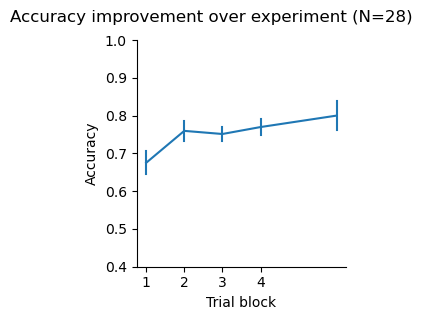

In [10]:
### Group by block 
to_analyze = results_df[(results_df['block_name'] != 'block_fourty')].copy()
practice_effect_summary = to_analyze.groupby(['participant', 'block_ix']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
N = practice_effect_summary.participant.nunique()
practice_effect_summary.columns = ['_'.join(col).strip() for col in practice_effect_summary.columns.values ]
# remove _ from end of each string
practice_effect_summary.columns = [col[:-1] if col[-1] == '_' else col for col in practice_effect_summary.columns]
# practice_effect_summary.loc[practice_effect_summary.block_ix == 5, "block_ix"] = 3
# practice_effect_summary = practice_effect_summary[practice_effect_summary.block_ix <4]
## Plot accuracy x block

cmap = sns.color_palette('Set2', n_colors=2)
palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


# N = practice_effect_summary.participant.nunique()   
g = sns.relplot(data=practice_effect_summary, x='block_ix', y='correct_mean',
                # hue='azim_delta', # hue_order=hue_order,
                errorbar=('se', 1),err_style='bars',
                height=3,
                palette=palette,    
                kind='line', aspect=1)
# set xticks to be the same as the azimuth deltas
g.set(xticks=np.arange(4), xticklabels=np.arange(1,5), yticks=np.arange(0.4, 1.1, 0.1))
# g.
g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Trial block", "Accuracy")
# g.legend.set_title("Azimuth\noffset\n(degrees)")


In [11]:
to_anova_practice = to_analyze.groupby(['participant', 'block_ix']).correct.mean().reset_index()
to_anova_practice = to_anova_practice[to_anova_practice.block_ix <= 4]

In [12]:
to_anova_practice[to_anova_practice.participant == 'participant_001']

,participant,block_ix,correct
0,participant_001,0,0.7625
1,participant_001,2,0.7625


In [13]:
# to_anova = results_summary[results_summary.block_name != 'block_fourty'].copy()
# practice_anova = practice_effect_summary.groupby(['participant', 'block_ix']).agg({'correct_mean': 'mean'}).reset_index()
# practice_anova['participant'] = practice_anova['participant'].astype('category')
# AnovaRM(to_anova_practice[to_anova_practice.block_ix <= 1], 'correct_mean', 'participant', within=['block_ix']).fit()

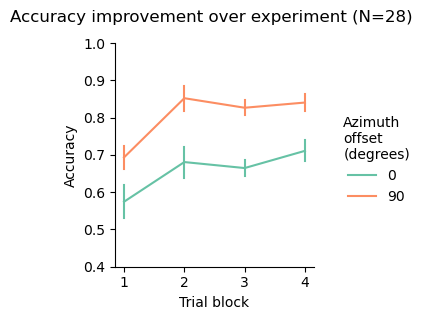

In [14]:
### Group by block 
to_analyze = results_df[(results_df['block_name'] != 'block_fourty') & (results_df.azim_delta.isin([0, 90]))].copy()
practice_effect_summary = to_analyze.groupby(['participant', 'block_ix', 'azim_delta']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
practice_effect_summary.columns = ['_'.join(col).strip() for col in practice_effect_summary.columns.values ]
# remove _ from end of each string
practice_effect_summary.columns = [col[:-1] if col[-1] == '_' else col for col in practice_effect_summary.columns]
practice_effect_summary.loc[practice_effect_summary.block_ix == 5, "block_ix"] = 3
## Plot accuracy x block

cmap = sns.color_palette('Set2', n_colors=2)
palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


N = practice_effect_summary.participant.nunique()   
g = sns.relplot(data=practice_effect_summary, x='block_ix', y='correct_mean',
                hue='azim_delta', # hue_order=hue_order,
                errorbar=('se', 1),err_style='bars',
                height=3,
                palette=palette,    
                kind='line', aspect=1)
# set xticks to be the same as the azimuth deltas
g.set(xticks=np.arange(4), xticklabels=np.arange(1,5), yticks=np.arange(0.4, 1.1, 0.1))
# g.
g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Trial block", "Accuracy")
g.legend.set_title("Azimuth\noffset\n(degrees)")


## Plot main human results plot

Text(0.5, 1.0, 'N=28 participants')

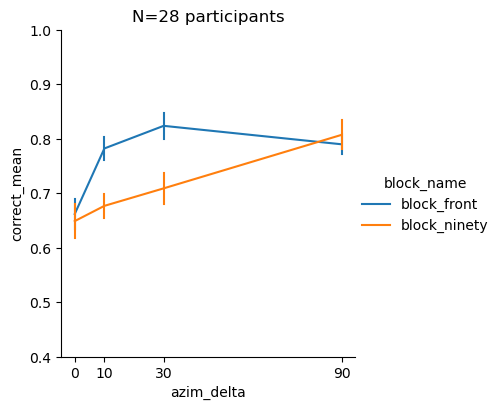

In [15]:
hue_order = ['block_front', 'block_ninety']
N = results_summary.participant.nunique()
g = sns.relplot(data=results_summary, x='azim_delta', y='correct_mean',
                 hue='block_name', hue_order=hue_order,
                 errorbar=('se', 1),err_style='bars',
                height=4,
                  kind='line', aspect=1)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.4, 1.1, 0.1))
plt.title(f"N={N} participants")

Text(0.5, 1.0, 'N=28 participants')

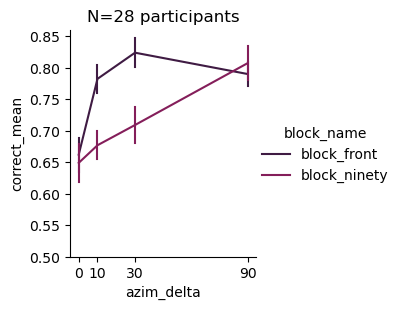

In [16]:
hue_order = ['block_front', 'block_fourty', 'block_ninety']
hue_order = ['block_front',  'block_ninety']
N = results_summary.participant.nunique()
cmap = sns.color_palette('rocket', n_colors=5)
palette = {target_azim: cmap[i] for i, target_azim in enumerate(['block_front', 'block_ninety'])}


g = sns.relplot(data=results_summary, x='azim_delta', y='correct_mean',
                 hue='block_name', hue_order=hue_order,
                 errorbar=('se', 1),err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=1)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.5, .86, 0.05), ylim=(0.5, 0.86))
plt.title(f"N={N} participants")

In [17]:
## Run ttest 
from scipy.stats import ttest_rel

for azim_delta in results_summary.azim_delta.unique():
    front = results_summary.loc[(results_summary['azim_delta'] == azim_delta) & (results_summary['block_name'] == 'block_front'), 'correct_mean']
    ninety = results_summary.loc[(results_summary['azim_delta'] == azim_delta) & (results_summary['block_name'] == 'block_ninety'), 'correct_mean']
    t, p = ttest_rel(front, ninety)
    print(f"t={t}, p={p}, azim_delta={azim_delta}")

t=0.32252348209698495, p=0.7495404042544882, azim_delta=0
t=3.9414859818393064, p=0.0005165613133824355, azim_delta=10
t=5.053966033835637, p=2.634496999851983e-05, azim_delta=30
t=-0.713954686963187, p=0.4813820631446618, azim_delta=90


### Run stats (2-way ANOVA)

In [56]:
results_summary

,participant,block_name,azim_delta,correct_mean,correct_count,confusions_mean
0,participant_001,block_fourty,0,0.55,20,0.10
1,participant_001,block_fourty,10,0.95,20,0.00
2,participant_001,block_fourty,30,0.85,20,0.00
3,participant_001,block_fourty,90,0.90,20,0.00
4,participant_001,block_front,0,0.65,20,0.05
...,...,...,...,...,...,...
247,participant_022_v01,block_front,90,0.85,20,0.00
248,participant_022_v01,block_ninety,0,0.90,20,0.00
249,participant_022_v01,block_ninety,10,0.70,20,0.05
250,participant_022_v01,block_ninety,30,0.75,20,0.05


In [18]:
to_anova = results_summary[results_summary.block_name != 'block_fourty'].copy()
to_anova.rename(columns={'block_name': 'target_azim', "azim_delta":'distractor_offset'}, inplace=True)

In [81]:
to_anova.to_csv('final_results_dir/experiment_7_human_for_ANOVA.csv', index=False)

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
# from scipy.stats import f
from statsmodels.stats.anova import AnovaRM


In [74]:
my_model_fit = AnovaRM(to_anova, 'correct_mean', 'participant', within=['target_azim', 'distractor_offset']).fit()
print(my_model_fit.anova_table)

                                 F Value  Num DF  Den DF        Pr > F
target_azim                     7.684569     1.0    27.0  9.966202e-03
distractor_offset              30.319909     3.0    81.0  3.057243e-13
target_azim:distractor_offset   6.730875     3.0    81.0  4.120668e-04


#### Use pingouin for effect size

In [75]:
from pingouin import rm_anova

human_rm_anova_table = rm_anova(data=to_anova, dv='correct_mean', subject='participant', within=["target_azim", 'distractor_offset'], effsize='np2')
print("ANOVA for humans")
human_rm_anova_table

ANOVA for humans


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,target_azim,0.163438,1,27,0.163438,7.684569,9.966202e-03,9.966202e-03,0.221556,1.000000
1,distractor_offset,0.636462,3,81,0.212154,30.319909,3.057243e-13,5.500018e-13,0.528959,0.976882
2,target_azim * distractor_offset,0.183353,3,81,0.061118,6.730875,4.120668e-04,1.292766e-03,0.199546,0.785780


## Plot human and model together

In [22]:
# ## import experiment word map
# human_exp_word_key = pickle.load( open(path_to_expmt_stim / "human_azim_spotlight_word_key.pkl", "rb" )) 
# exp_word_2_class = {v:k for k,v in human_exp_word_key.items()}

In [23]:
# list(Path(f"binaural_eval/sim_azim_spotlight_v02_min_reverb_room1004_30dB_pink_noise_bg/").glob("*/*50Hz*.pkl"))


In [24]:
# Path to results 

cols_to_merge = ['stim_name',
                 'word',
                 'sex_cond',
                 'target_transcripts',
                 'distractor_transcripts',
                 'distractor_word',

]

# output_paths = list(Path("binaural_eval/word_task_voice_loc_cue_only_v04").glob("*.pkl")) old path for more locations
import pickle
# match human pilot conditions
# model_name = 'word_task_half_co_loc_v06'
# output_paths = list(Path(f"binaural_eval/sim_azim_spotlight_v02/").glob("*/*.pkl"))
output_paths = list(Path(f"binaural_eval/sim_azim_spotlight_v02_min_reverb_room1004_30dB_pink_noise_bg/").glob("*/*v10*.pkl"))
output_paths += list(Path(f"binaural_eval/sim_azim_spotlight_v02_min_reverb_room1004_30dB_pink_noise_bg/").glob("*/*50Hz*.pkl"))

word_class_map = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
ix_to_word = {v:k for k,v in word_class_map.items()}

remap_azim = lambda azim: 360 - azim if azim > 180 else 0 - azim 

results_dfs = []

# model_name_dict = {
#                    "word_task_half_co_loc_v09_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout": 'Feature-gain Model',
#                    "word_task_v10_main_feature_gain_config": 'Feature-gain Model'
#                   }


gend_map = {True:'same', False:'diff'}

for path in output_paths:
    # if not any(name in str(path) for name in ['word_task_v10_main_feature_gain_config']):# 'word_task_half_co_loc_v08']):
    #     continue

    # res_dict = pickle.load(open(path, 'rb'))
    try:
        df = pd.DataFrame(pd.read_pickle(path))
    
        df['response'] = df['preds'].replace(ix_to_word)
        df['true_word'] = df['true_word_int'].replace(ix_to_word)
        # df['confusions'] = (df.response == df.distractor_word).astype('int')
        # df['accuracy'] = (df.response == df.word).astype('int')


        # # add adjusted accuracy and confusions 
        # pred_words = df.response.values
        # target_words = df.word.values
        # target_transcripts = df.target_transcripts.values
        # distractor_words = df.distractor_word.values
        # distractor_transcripts = df.distractor_transcripts.values


        # adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
        #                             if not isinstance(target_transcript, float) else np.nan
        #                             for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
        #                             ])

        # adjusted_confs = np.array([int(pred_word in distractor_transcript or pred_word == dist_word)
        #                             if not (isinstance(distractor_transcript, float)) else np.nan
        #                             for pred_word, dist_word, distractor_transcript in zip(pred_words, distractor_words,  distractor_transcripts)
        #                             ])

        # df['accuracy'] = adjusted_acc
        # df['confusions'] = adjusted_confs
        df.rename(columns={"results": "accuracy"}, inplace=True)

        df['target_azim'] = int(re.search('target_loc_(-?\d+)', path.stem).group(0).strip('target_loc_'))
        df['distractor_azim'] = int(re.search('distract_loc_(-?\d+)', path.stem).group(0).strip('distract_loc_'))
        df['target_azim'] = df['target_azim'].apply(remap_azim)
        df['distractor_azim'] = df['distractor_azim'].apply(remap_azim)
        
        
        # df.rename(columns={"results": "accuracy"}, inplace=True)
        # df['model'] = model_name_dict[path.parent.stem]
        df['model'] = path.parent.stem
        results_dfs.append(df)
    except Exception as error:
        print(error)
        print(path)
        continue


model_results = pd.concat(results_dfs)


In [25]:
model_results.model.value_counts()

model
word_task_early_only_v10                  29280
word_task_late_only_v10                   29280
word_task_v10_4MGB_ln_first_arch_1        29280
word_task_v10_4MGB_ln_first_arch_10       29280
word_task_v10_4MGB_ln_first_arch_12       29280
word_task_v10_4MGB_ln_first_arch_2        29280
word_task_v10_4MGB_ln_first_arch_4        29280
word_task_v10_4MGB_ln_first_arch_6        29280
word_task_v10_4MGB_ln_first_arch_7        29280
word_task_v10_4MGB_ln_first_arch_8        29280
word_task_v10_4MGB_ln_first_arch_9        29280
word_task_v10_backbone_word_config        29280
word_task_v10_control_no_attn             29280
word_task_v10_main_feature_gain_config    29280
word_task_half_co_loc_v09_50Hz_cutoff     29280
Name: count, dtype: int64

In [26]:
model_results.target_azim.abs().unique(), model_results.distractor_azim.abs().unique()

(array([ 0, 90]), array([ 0, 10, 90, 30, 80, 60]))

In [27]:
model_results

,accuracy,confusions,preds,true_word_int,stim_ix_list,response,true_word,target_azim,distractor_azim,model
0,1,0,0,0,0,about,about,0,0,word_task_early_only_v10
1,0,0,228,1,1,eventually,above,0,0,word_task_early_only_v10
2,0,0,587,2,2,rights,access,0,0,word_task_early_only_v10
3,1,0,4,4,3,across,across,0,0,word_task_early_only_v10
4,0,1,65,5,4,believe,action,0,0,word_task_early_only_v10
...,...,...,...,...,...,...,...,...,...,...
1947,1,0,791,791,1947,writing,writing,-90,-90,word_task_half_co_loc_v09_50Hz_cutoff
1948,0,0,592,792,1948,route,written,-90,-90,word_task_half_co_loc_v09_50Hz_cutoff
1949,0,0,558,793,1949,really,wrote,-90,-90,word_task_half_co_loc_v09_50Hz_cutoff
1950,1,0,795,795,1950,yellow,yellow,-90,-90,word_task_half_co_loc_v09_50Hz_cutoff


## Plot humans with model

In [59]:
human_to_merge

,participant,Target azimuth,azim_delta,accuracy,correct_count,confusions,group
0,participant_001,0,0,0.65,20,0.05,Humans (N=28)
1,participant_001,0,10,0.65,20,0.00,Humans (N=28)
2,participant_001,0,30,0.80,20,0.00,Humans (N=28)
3,participant_001,0,90,0.95,20,0.00,Humans (N=28)
4,participant_001,90,0,0.85,20,0.00,Humans (N=28)
...,...,...,...,...,...,...,...
219,participant_022_v01,0,90,0.85,20,0.00,Humans (N=28)
220,participant_022_v01,90,0,0.90,20,0.00,Humans (N=28)
221,participant_022_v01,90,10,0.70,20,0.05,Humans (N=28)
222,participant_022_v01,90,30,0.75,20,0.05,Humans (N=28)


In [61]:
## Get and format model data for merging with human data
model_to_merge = model_results.copy()
model_to_merge['target_azim'] = model_to_merge['target_azim'].abs()
model_to_merge['distractor_azim'] = model_to_merge['distractor_azim'].abs()
model_to_merge['azim_delta'] = np.abs(model_to_merge['distractor_azim'] - model_to_merge['target_azim'])
model_to_merge = model_to_merge[model_to_merge['azim_delta'].isin([0, 10, 30, 90])]
model_to_merge['group'] = model_to_merge['model']
model_to_merge.rename(columns={'target_azim':'Target azimuth'}, inplace=True)
# same for human data
human_to_merge = results_summary[results_summary.block_name != 'block_fourty'].copy().reset_index(drop=True)
human_to_merge.rename(columns={'block_name': 'Target azimuth', 'correct_mean':'accuracy', 'confusions_mean':'confusions'}, inplace=True)
# rename values in column target azimuth 
human_to_merge['Target azimuth'] = human_to_merge['Target azimuth'].replace({'block_front': 0, 'block_ninety': 90})
N = human_to_merge.participant.nunique()
human_to_merge["group"] = f"Humans (N={N})"
human_to_merge['model'] = human_to_merge['participant']

# merge 
merged_df = pd.concat([model_to_merge, human_to_merge], ignore_index=True)
merged_df.dropna(axis=1, inplace=True)
merged_df['azim_delta'] = merged_df['azim_delta'].astype(int)
merged_df['Target azimuth'] = merged_df['Target azimuth'].astype(int)

/tmp/ipykernel_3505957/480138029.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  human_to_merge['Target azimuth'] = human_to_merge['Target azimuth'].replace({'block_front': 0, 'block_ninety': 90})


In [ ]:
merged_df.to_csv(fig_out_dir / "merged_human_model_results.csv", index=False)

,accuracy,confusions,Target azimuth,model,azim_delta,group
0,1.00,0.00,0,word_task_early_only_v10,0,word_task_early_only_v10
1,0.00,0.00,0,word_task_early_only_v10,0,word_task_early_only_v10
2,0.00,0.00,0,word_task_early_only_v10,0,word_task_early_only_v10
3,1.00,0.00,0,word_task_early_only_v10,0,word_task_early_only_v10
4,0.00,1.00,0,word_task_early_only_v10,0,word_task_early_only_v10
...,...,...,...,...,...,...
439419,0.85,0.00,0,participant_022_v01,90,Humans (N=28)
439420,0.90,0.00,90,participant_022_v01,0,Humans (N=28)
439421,0.70,0.05,90,participant_022_v01,10,Humans (N=28)
439422,0.75,0.05,90,participant_022_v01,30,Humans (N=28)


### Plot model architectures first 

In [29]:
# # hue_order = [0,  90]

# cmap = sns.color_palette('rocket', n_colors=5)
# palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


# g = sns.relplot(data=model_to_merge, x='azim_delta', y='accuracy',
#                  hue='Target azimuth', hue_order=hue_order,
#                  col='group', col_wrap=1,
#                  errorbar=('se', 1),err_style='bars',
#                 height=3,
#                 palette=palette,
#                 kind='line', aspect=0.75)
# # set xticks to be the same as the azimuth deltas
# g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.40, .91, 0.1))
# g.set_titles("{col_name}")
# # plt.title(f"N={N} participants")
# g.set_axis_labels("Azimuth offset (degrees)", "Accuracy")


### Plot model average with humans

In [30]:
merged_df.group.unique()

array(['word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'Humans (N=28)'],
      dtype=object)

In [31]:
merged_df['model'] = merged_df['group'].copy()
merged_df['group'] = [util_analysis.get_model_name(name) for name in merged_df.model.values]

# merged_df.loc[merged_df.model.str.contains('main|arch'), 'group'] = 'Feature-gain Model'
# merged_df.loc[merged_df.model.str.contains('early'), 'group'] = 'Early-only'
# merged_df.loc[merged_df.model.str.contains('late'), 'group'] = 'Late-only'
# merged_df.loc[merged_df.model.str.contains('control'), 'group'] = 'Baseline CNN'
# merged_df.loc[merged_df.model.str.contains('50Hz'), 'group'] = '50Hz cutoff'
# merged_df.loc[merged_df.model.str.contains('backbone'), 'group'] = 'Computed-gain model'


In [32]:
merged_df.group.unique()

array(['Early-only', 'Late-only', 'Feature-gain alt v1',
       'Feature-gain alt v10', 'Feature-gain alt v12',
       'Feature-gain alt v2', 'Feature-gain alt v4',
       'Feature-gain alt v6', 'Feature-gain alt v7',
       'Feature-gain alt v8', 'Feature-gain alt v9', 'Backbone',
       'Baseline CNN', 'Feature-gain main', '50Hz cutoff',
       'Humans (N=28)'], dtype=object)

In [63]:
merged_df.model.unique()

array(['word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'participant_001',
       'participant_001_v01', 'participant_002_v01',
       'participant_003_v01', 'participant_004_v01',
       'participant_005_v01', 'participant_006', 'participant_006_v01',
       'participant_007', 'participant_007_v01', 'participant_008',
       'participant_008_v01', 'participant_009', 'participant_009_v01',
       'part

In [67]:
merged_df.group.unique()

array(['word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_backbone_word_config',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config',
       'word_task_half_co_loc_v09_50Hz_cutoff', 'Humans (N=28)'],
      dtype=object)

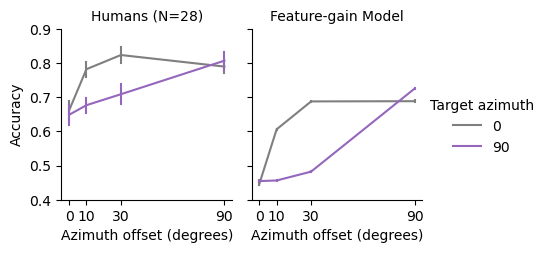

In [ ]:
hue_order = [0,  90]

cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]

col_order = ['Humans (N=28)', 'Feature-gain Model',]# 'Early-only', 'Late-only', 'Baseline CNN']
to_plot = merged_df.copy()
to_plot.loc[to_plot.model.str.contains('arch|main'), 'group'] = 'Feature-gain Model'

g = sns.relplot(data=to_plot, x='azim_delta', y='accuracy',
                 hue='Target azimuth', hue_order=hue_order,
                 col='group', col_order=col_order,
                 errorbar=('se', 1),
                 err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=0.75)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.40, .91, 0.1))
g.set_titles("{col_name}")
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Accuracy")

# make aspect square

ratio = 1 

for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

# g.savefig(fig_out_dir / "figure_4_model_human_accuracy.pdf", transparent=True, bbox_inches='tight')

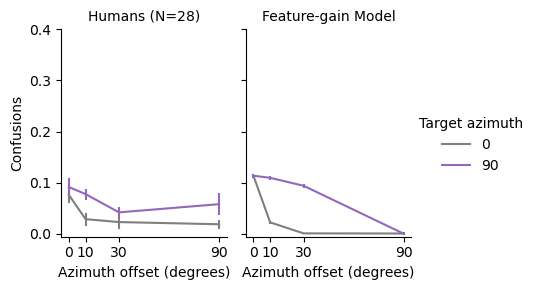

In [35]:
hue_order = [0,  90]

cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]

col_order = ['Humans (N=28)', 'Feature-gain Model',]# 'Early-only', 'Late-only', 'Baseline CNN']
to_plot = merged_df.copy()
to_plot.loc[to_plot.model.str.contains('arch|main'), 'group'] = 'Feature-gain Model'
g = sns.relplot(data=to_plot, x='azim_delta', y='confusions',
                 hue='Target azimuth', hue_order=hue_order,
                 col='group', col_order=col_order,
                 errorbar=('se', 1),
                 err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=0.75)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.0, .41, 0.1))
g.set_titles("{col_name}")
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Confusions")


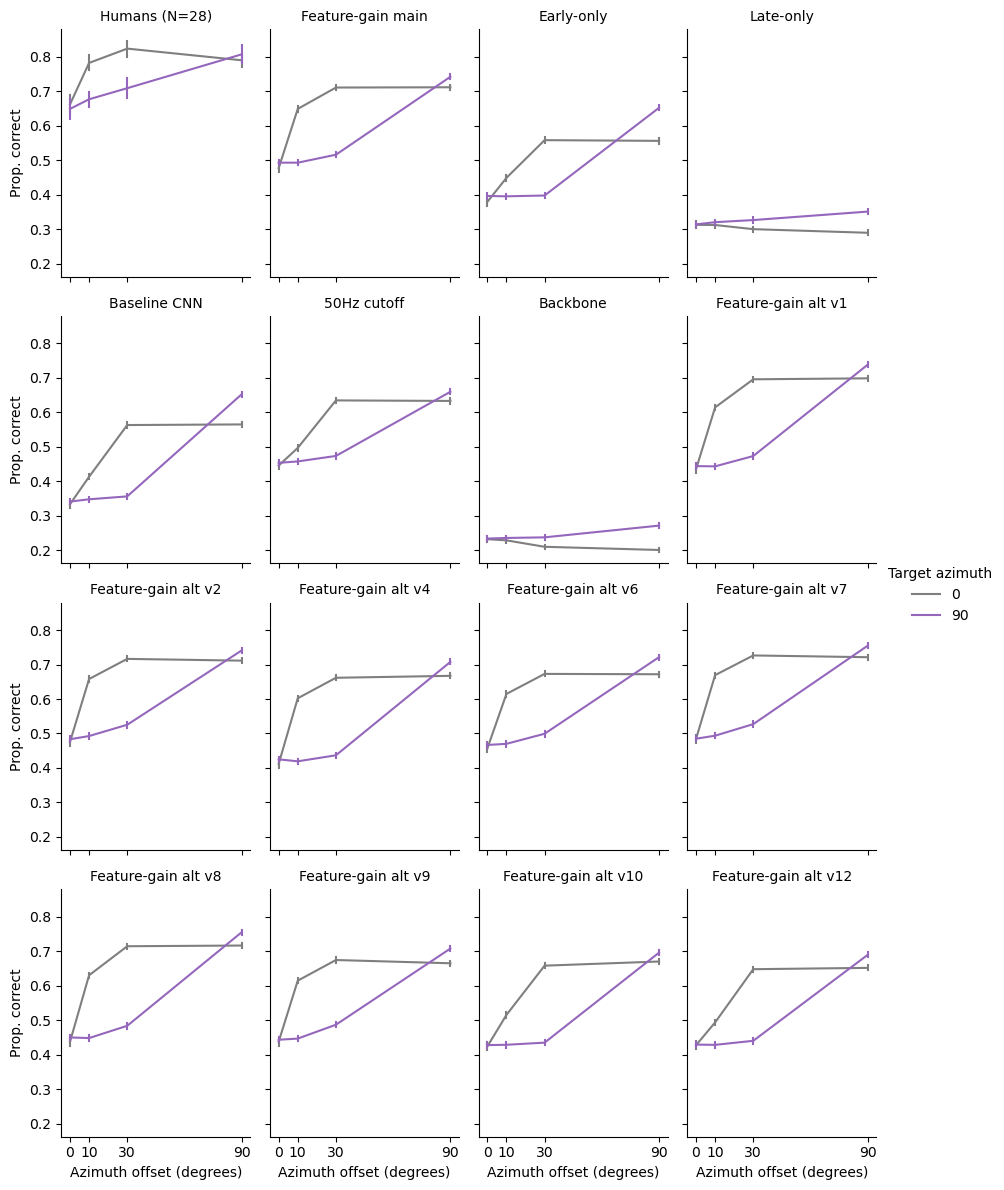

In [36]:
hue_order = [0,  90]

cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]

all_models = [util_analysis.get_model_name(name) for name in merged_df.model.unique()]

col_order = ['Humans (N=28)', 'Feature-gain main', 'Early-only','Late-only', "Baseline CNN", "50Hz cutoff", "Backbone"]
also_sort = [m for m in all_models if m not in col_order]
col_order += sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group()))

col_order = [m for m in col_order if m in all_models]


g = sns.relplot(data=merged_df, x='azim_delta', y='accuracy',
                 hue='Target azimuth', hue_order=hue_order,
                 col='group', col_order=col_order, col_wrap=4,
                 errorbar=('se', 1),
                 err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=0.75)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(),)
g.set_titles("{col_name}")
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Prop. correct")


## Package and save out for human-model similarity plots 

### Save model and human for plots 

In [68]:
merged_df
merged_df.loc[merged_df.model.str.contains('main|arch'), 'group'] = 'Feature-gain Model'
merged_df.loc[merged_df.model.str.contains('early'), 'group'] = 'Early-only'
merged_df.loc[merged_df.model.str.contains('late'), 'group'] = 'Late-only'
merged_df.loc[merged_df.model.str.contains('control'), 'group'] = 'Baseline CNN'
merged_df.loc[merged_df.model.str.contains('50Hz'), 'group'] = '50Hz cutoff'
merged_df.loc[merged_df.model.str.contains('backbone'), 'group'] = 'Computed-gain model'

In [71]:
to_print = merged_df[~merged_df.group.str.contains('Computed|50')].reset_index(drop=True)
to_print

,accuracy,confusions,Target azimuth,model,azim_delta,group
0,1.00,0.00,0,word_task_early_only_v10,0,Early-only
1,0.00,0.00,0,word_task_early_only_v10,0,Early-only
2,0.00,0.00,0,word_task_early_only_v10,0,Early-only
3,1.00,0.00,0,word_task_early_only_v10,0,Early-only
4,0.00,1.00,0,word_task_early_only_v10,0,Early-only
...,...,...,...,...,...,...
380859,0.85,0.00,0,participant_022_v01,90,Humans (N=28)
380860,0.90,0.00,90,participant_022_v01,0,Humans (N=28)
380861,0.70,0.05,90,participant_022_v01,10,Humans (N=28)
380862,0.75,0.05,90,participant_022_v01,30,Humans (N=28)


In [37]:
#### Summarize dfs for saving 

## Human df - human_to_merge is participant_level summary 
human_total_summary = human_to_merge.groupby(['Target azimuth', 'azim_delta']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
human_total_summary.columns = ['target_azim', 'azim_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
human_total_summary['model'] = human_to_merge['group'].unique()[0]
human_total_summary['group'] = human_to_merge['group'].unique()[0]
#### Model dfs 

to_summary = merged_df[~merged_df['group'].str.contains("Human")].copy()
all_model_summary = to_summary.groupby(['model','Target azimuth', 'azim_delta']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
all_model_summary.columns = ['model', 'target_azim', 'azim_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
all_model_summary.loc[all_model_summary.model.str.contains('main|arch'), 'group'] = 'Feature-gain Model'
all_model_summary.loc[all_model_summary.model.str.contains('early'), 'group'] = 'Early-only'
all_model_summary.loc[all_model_summary.model.str.contains('late'), 'group'] = 'Late-only'
all_model_summary.loc[all_model_summary.model.str.contains('control'), 'group'] = 'Baseline CNN'
all_model_summary.loc[all_model_summary.model.str.contains('50Hz'), 'group'] = '50Hz cutoff'
all_model_summary.loc[all_model_summary.model.str.contains('backbone'), 'group'] = 'Computed-gain model'
print(all_model_summary.model.value_counts())


grouped_for_stats = pd.concat([human_total_summary, all_model_summary], ignore_index=True)


## Summarize fba models 
fba_total_summary = all_model_summary[all_model_summary.model.str.contains('main|arch')].copy()
fba_total_summary = fba_total_summary.groupby(['target_azim', 'azim_delta']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
fba_total_summary.columns = ['target_azim', 'azim_delta', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
fba_total_summary['model'] = 'Feature-gain Model'
fba_total_summary['group'] = 'Feature-gain Model'

# fba_total_summary

## Save group for stats
out_dir = Path("final_results_dir")

out_name = out_dir / f"df_for_stats_and_summary_2024_spotlight_humans_N-28_models_v10_w_control_50Hz_ECDF_models.pdpkl"
# grouped_for_stats.to_pickle(out_name)

model
word_task_early_only_v10                  8
word_task_half_co_loc_v09_50Hz_cutoff     8
word_task_late_only_v10                   8
word_task_v10_4MGB_ln_first_arch_1        8
word_task_v10_4MGB_ln_first_arch_10       8
word_task_v10_4MGB_ln_first_arch_12       8
word_task_v10_4MGB_ln_first_arch_2        8
word_task_v10_4MGB_ln_first_arch_4        8
word_task_v10_4MGB_ln_first_arch_6        8
word_task_v10_4MGB_ln_first_arch_7        8
word_task_v10_4MGB_ln_first_arch_8        8
word_task_v10_4MGB_ln_first_arch_9        8
word_task_v10_backbone_word_config        8
word_task_v10_control_no_attn             8
word_task_v10_main_feature_gain_config    8
Name: count, dtype: int64


In [38]:
grouped_for_stats.group.value_counts()

group
Feature-gain Model     80
Early-only              8
Humans (N=28)           8
50Hz cutoff             8
Late-only               8
Computed-gain model     8
Baseline CNN            8
Name: count, dtype: int64

In [52]:
## Save to share 

to_share = grouped_for_stats[~grouped_for_stats.group.str.contains('50|Computed')].reset_index(drop=True)
to_share

,target_azim,azim_delta,accuracy,accuracy_sem,confusions,confusions_sem,model,group
0,0,0,0.661905,0.026875,0.076190,0.014533,Humans (N=28),Humans (N=28)
1,0,10,0.782228,0.021695,0.028997,0.010619,Humans (N=28),Humans (N=28)
2,0,30,0.823747,0.023287,0.023308,0.011360,Humans (N=28),Humans (N=28)
3,0,90,0.789881,0.018333,0.019048,0.006896,Humans (N=28),Humans (N=28)
4,90,0,0.648810,0.030657,0.091667,0.016254,Humans (N=28),Humans (N=28)
...,...,...,...,...,...,...,...,...
107,0,90,0.711578,0.007251,0.001537,0.000627,word_task_v10_main_feature_gain_config,Feature-gain Model
108,90,0,0.492828,0.008003,0.112961,0.005067,word_task_v10_main_feature_gain_config,Feature-gain Model
109,90,10,0.492828,0.008003,0.109631,0.005001,word_task_v10_main_feature_gain_config,Feature-gain Model
110,90,30,0.515881,0.007999,0.093750,0.004666,word_task_v10_main_feature_gain_config,Feature-gain Model


In [53]:
to_share.to_csv(out_dir / 'experiment_7_df.csv', index=False)

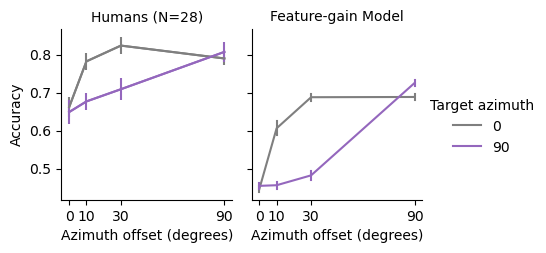

In [50]:
hue_order = [0,  90]

cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]

col_order = ['Humans (N=28)', 'Feature-gain Model',]# 'Early-only', 'Late-only', 'Baseline CNN']
to_plot = to_share.copy()
to_plot.rename(columns={'target_azim':'Target azimuth'}, inplace=True)
# to_plot.loc[to_plot.model.str.contains('arch|main'), 'group'] = 'Feature-gain Model'

g = sns.relplot(data=to_plot, x='azim_delta', y='accuracy',
                 hue='Target azimuth', hue_order=hue_order,
                 col='group', col_order=col_order,
                 errorbar=('se', 1),
                 err_style='bars',
                height=3,
                palette=palette,
                kind='line', aspect=0.75)
# set xticks to be the same as the azimuth deltas
g.set(xticks=results_summary['azim_delta'].unique(), yticks=np.arange(0.40, .91, 0.1))
g.set_titles("{col_name}")
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Accuracy")


# add error to human plot 
for group, selected in to_plot[to_plot.group.str.contains('Human')].groupby('Target azimuth'):
    # plot the errorbar with the correct color for each group 
    sem = selected['accuracy_sem'] 
    # add errorbar as fill_between 
    g.axes[0,0].errorbar(selected['azim_delta'], selected['accuracy'], yerr=sem, color=palette[group], alpha=1)



# make aspect square

ratio = 1 

for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

# g.savefig(fig_out_dir / "figure_4_model_human_accuracy.pdf", transparent=True, bbox_inches='tight')

## Make practice effect supplement plots

,target_azim,azim_delta,accuracy,accuracy_sem,confusions,confusions_sem,model,group
0,0,0,0.661905,0.026875,0.076190,0.014533,Humans (N=28),Humans (N=28)
1,0,10,0.782228,0.021695,0.028997,0.010619,Humans (N=28),Humans (N=28)
2,0,30,0.823747,0.023287,0.023308,0.011360,Humans (N=28),Humans (N=28)
3,0,90,0.789881,0.018333,0.019048,0.006896,Humans (N=28),Humans (N=28)
4,90,0,0.648810,0.030657,0.091667,0.016254,Humans (N=28),Humans (N=28)
...,...,...,...,...,...,...,...,...
123,0,90,0.711578,0.007251,0.001537,0.000627,word_task_v10_main_feature_gain_config,Feature-gain Model
124,90,0,0.492828,0.008003,0.112961,0.005067,word_task_v10_main_feature_gain_config,Feature-gain Model
125,90,10,0.492828,0.008003,0.109631,0.005001,word_task_v10_main_feature_gain_config,Feature-gain Model
126,90,30,0.515881,0.007999,0.093750,0.004666,word_task_v10_main_feature_gain_config,Feature-gain Model


In [45]:
## Get and format model data for merging with human data
model_to_merge = grouped_for_stats[grouped_for_stats.group == 'Feature-gain Model'].copy()
model_to_merge.rename(columns={'target_azim':'Target azimuth', 'model':'participant'}, inplace=True)
# same for human data
human_to_merge = results_df[(results_df['block_name'] != 'block_fourty') ].copy()
human_to_merge = human_to_merge.groupby(['participant', 'block_ix', 'block_name', 'azim_delta']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
human_to_merge.columns = ['_'.join(col).strip() for col in human_to_merge.columns.values ]
# remove _ from end of each string
human_to_merge.columns = [col[:-1] if col[-1] == '_' else col for col in human_to_merge.columns]
human_to_merge.loc[human_to_merge.block_ix == 5, "block_ix"] = 3
human_to_merge = human_to_merge[(human_to_merge.block_ix.isin([0, 3]))]
human_to_merge.loc[human_to_merge.block_ix == 0, "block_order"] = '\nfirst block'
human_to_merge.loc[human_to_merge.block_ix == 3, "block_order"] = '\nlast block'


N = human_to_merge.participant.nunique()
human_to_merge.loc[human_to_merge.block_name == 'block_front', 'Target azimuth'] = 0
human_to_merge.loc[human_to_merge.block_name == 'block_ninety', 'Target azimuth'] = 90
human_to_merge['Target azimuth'] = human_to_merge['Target azimuth'].astype(int)
human_to_merge["group"] = f"Humans (N={N}) " + human_to_merge['block_order'].astype(str)
human_to_merge.rename(columns={'correct_mean':'accuracy'}, inplace=True)


# # merge 
practice_effect_df = pd.concat([model_to_merge, human_to_merge], ignore_index=True)
practice_effect_df.dropna(axis=1, inplace=True)
practice_effect_df['azim_delta'] = practice_effect_df['azim_delta'].astype(int)
practice_effect_df['Target azimuth'] = practice_effect_df['Target azimuth'].astype(int)

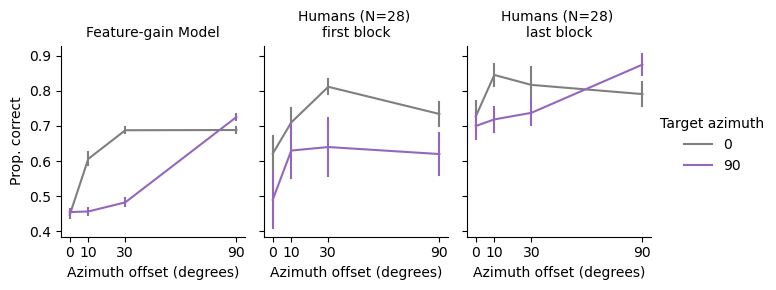

In [46]:
cmap = sns.color_palette('tab10', n_colors=8)
palette={}
palette[0] = cmap[7]
palette[90] = cmap[4]
g = sns.relplot(data=practice_effect_df, x='azim_delta', y='accuracy',
            hue='Target azimuth', 
            col='group', #col_order=[0, 3],
            # # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3, aspect=0.75,
            palette=palette,
            kind='line')
# g.set(xticks=[0,3], xticklabels=['First', 'Last'], )
# g.axes[0,0].axhline(y=model_mean_acc, linestyle='--', color='black')
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
# g.legend.set_title("Azimuth\noffset\n(degrees)")
g.set(xticks=results_summary['azim_delta'].unique(),)
g.set_titles("{col_name}")

g.set_axis_labels("Azimuth offset (degrees)", "Prop. correct")

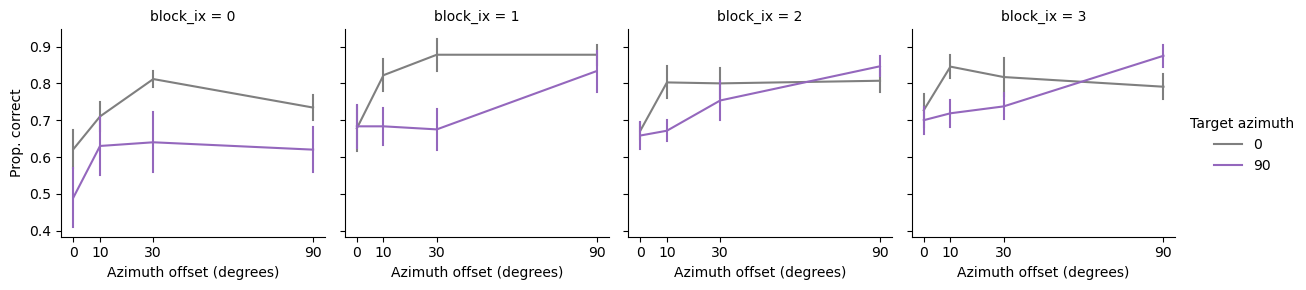

In [47]:
### Simplify practice effect plot
model_acc_mean, model_acc_sem = grouped_for_stats[grouped_for_stats.group == 'Feature-gain Model'].accuracy.agg(['mean', 'sem'])

### Plot human results at 
### Group by block 
to_analyze = results_df[(results_df['block_name'] != 'block_fourty') ].copy()
practice_effect_summary = to_analyze.groupby(['participant', 'block_ix', 'block_name', 'azim_delta']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
practice_effect_summary.columns = ['_'.join(col).strip() for col in practice_effect_summary.columns.values ]
# remove _ from end of each string
practice_effect_summary.columns = [col[:-1] if col[-1] == '_' else col for col in practice_effect_summary.columns]
practice_effect_summary.loc[practice_effect_summary.block_ix == 5, "block_ix"] = 3
## Plot accuracy x block

to_plot = practice_effect_summary# [(practice_effect_summary.block_ix.isin([0, 3]))]
to_plot.loc[to_plot.block_name == 'block_front', 'Target azimuth'] = 0
to_plot.loc[to_plot.block_name == 'block_ninety', 'Target azimuth'] = 90
to_plot['Target azimuth'] = to_plot['Target azimuth'].astype(int)
# get model human difference 
# to_plot.loc[to_plot.azim_delta == 0, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 0, 'correct_mean'] - model_acc_at_0
# to_plot.loc[to_plot.azim_delta == 90, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 90, 'correct_mean'] - model_acc_at_90

# cmap = sns.color_palette('Set2', n_colors=2)
# palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


g = sns.relplot(data=to_plot, x='azim_delta', y='correct_mean',
            hue='Target azimuth', 
            col='block_ix', #col_order=[0, 3],
            # # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            palette=palette,
            kind='line', aspect=1)
# g.set(xticks=[0,3], xticklabels=['First', 'Last'], )
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
# g.legend.set_title("Azimuth\noffset\n(degrees)")
g.set(xticks=results_summary['azim_delta'].unique(),)
# plt.title(f"N={N} participants")
g.set_axis_labels("Azimuth offset (degrees)", "Prop. correct")

In [48]:
to_plot

,participant,block_ix,block_name,azim_delta,correct_mean,correct_count,confusions_mean,confusions_count,Target azimuth
0,participant_001,0,block_front,0,0.650000,20,0.05,20,0
1,participant_001,0,block_front,10,0.650000,20,0.00,20,0
2,participant_001,0,block_front,30,0.800000,20,0.00,20,0
3,participant_001,0,block_front,90,0.950000,20,0.00,20,0
4,participant_001,2,block_ninety,0,0.850000,20,0.00,20,90
...,...,...,...,...,...,...,...,...,...
411,participant_022_v01,2,block_front,90,0.900000,10,0.00,10,0
412,participant_022_v01,3,block_front,0,0.800000,10,0.00,10,0
413,participant_022_v01,3,block_front,10,0.900000,10,0.00,10,0
414,participant_022_v01,3,block_front,30,0.888889,9,0.00,9,0


In [49]:
sns.color_palette("viridis", as_cmap=True)(0.5)

(0.127568, 0.566949, 0.550556, 1.0)

/tmp/ipykernel_3505957/2254251662.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot['performance_delta'] = to_plot['correct_mean'] - model_acc_mean


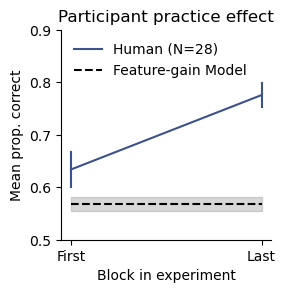

In [83]:
### Simplify practice effect plot
model_acc_mean, model_acc_sem = grouped_for_stats[grouped_for_stats.group == 'Feature-gain Model'].accuracy.agg(['mean', 'sem'])



### Plot human results at 
### Group by block 
to_analyze = results_df[(results_df['block_name'] != 'block_fourty') & (results_df.azim_delta.isin([0, 90]))].copy()
practice_effect_summary = to_analyze.groupby(['participant', 'block_ix']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
practice_effect_summary.columns = ['_'.join(col).strip() for col in practice_effect_summary.columns.values ]
# remove _ from end of each string
practice_effect_summary.columns = [col[:-1] if col[-1] == '_' else col for col in practice_effect_summary.columns]
practice_effect_summary.loc[practice_effect_summary.block_ix == 5, "block_ix"] = 3
## Plot accuracy x block

to_plot = practice_effect_summary[(practice_effect_summary.block_ix.isin([0, 3]))]


# get model human difference 
# to_plot.loc[to_plot.azim_delta == 0, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 0, 'correct_mean'] - model_acc_at_0
to_plot['performance_delta'] = to_plot['correct_mean'] - model_acc_mean

cmap = sns.color_palette('Set2', n_colors=2)
palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


human_color = sns.color_palette("viridis", as_cmap=True)(0.25)

g = sns.relplot(data=to_plot, x='block_ix', y='correct_mean',
            # hue='azim_delta', # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            color=human_color,
            kind='line', aspect=1)
g.set(xticks=[0,3], xticklabels=['First', 'Last'], )
# add error bar for model mean accuracy
ax = g.axes[0,0]
ax.plot([0,3], [model_acc_mean] *2, '--k')
ax.set_ylim(0.5,.9)

## Add legend manually 

legend_handles = [
    Line2D([0], [0], marker='', color=human_color,
           label=f"Human (N={N})",
           markerfacecolor=human_color,
           )
           ,   
        Line2D([0], [0], ls='--', color='k',
           label=f"Feature-gain Model",
           markerfacecolor='k',
           )
            ]

fontsize=10

color_legend = ax.legend(handles=legend_handles, title="", frameon=False,
                              loc='upper left', fontsize=fontsize, title_fontsize=fontsize,
                              bbox_to_anchor=(0, 1),
                            #   bbox_transform=fig.transFigure
                              ) 
ax.fill_between([0,3], model_acc_mean + model_acc_sem,  model_acc_mean - model_acc_sem, alpha=0.3, color='grey')
# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Block in experiment", "Mean prop. correct")
# g.legend.set_title("Azimuth\noffset\n(degrees)")
ax.set_title('Participant practice effect', fontsize=12,)

## Make panel aspect square 
ratio = 1.0 
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
g.savefig(fig_out_dir / "figure_4_model_practice_effect.pdf", transparent=True, bbox_inches='tight')

In [84]:
to_plot.to_csv(out_dir / "experiment_7_human_practice_effect_summary.csv", index=False)

/tmp/ipykernel_3896555/2873138665.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.loc[to_plot.azim_delta == 0, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 0, 'correct_mean'] - model_acc_at_0


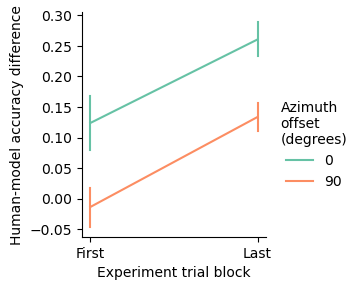

In [213]:
### Simplify practice effect plot
model_perf = grouped_for_stats[grouped_for_stats.group == 'Feature-gain Model'].groupby(['azim_delta']).accuracy.mean().reset_index()
model_acc_at_0 = model_perf[model_perf['azim_delta'] == 0].accuracy.mean()
model_acc_at_90 = model_perf[model_perf['azim_delta'] == 90].accuracy.mean()


### Plot human results at 
### Group by block 
to_analyze = results_df[(results_df['block_name'] != 'block_fourty') & (results_df.azim_delta.isin([0, 90]))].copy()
practice_effect_summary = to_analyze.groupby(['participant', 'block_ix', 'azim_delta']).agg({'correct': ['mean' ,"count"], 'confusions':['mean', "count"]}).reset_index()
# flatten multiindex
practice_effect_summary.columns = ['_'.join(col).strip() for col in practice_effect_summary.columns.values ]
# remove _ from end of each string
practice_effect_summary.columns = [col[:-1] if col[-1] == '_' else col for col in practice_effect_summary.columns]
practice_effect_summary.loc[practice_effect_summary.block_ix == 5, "block_ix"] = 3
## Plot accuracy x block

to_plot = practice_effect_summary[(practice_effect_summary.block_ix.isin([0, 3]))]


# get model human difference 
to_plot.loc[to_plot.azim_delta == 0, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 0, 'correct_mean'] - model_acc_at_0
to_plot.loc[to_plot.azim_delta == 90, 'performance_delta'] = to_plot.loc[to_plot.azim_delta == 90, 'correct_mean'] - model_acc_at_90

cmap = sns.color_palette('Set2', n_colors=2)
palette = {target_azim: cmap[i] for i, target_azim in enumerate([0, 90])}


g = sns.relplot(data=to_plot, x='block_ix', y='performance_delta',
            hue='azim_delta', # hue_order=hue_order,
            errorbar=('se', 1),err_style='bars',
            height=3,
            palette=palette,
            kind='line', aspect=1)
g.set(xticks=[0,3], xticklabels=['First', 'Last'], )

# g.fig.suptitle(f"Accuracy improvement over experiment (N={N})", y=1.05)
g.set_axis_labels("Experiment trial block", "Human-model accuracy difference")
g.legend.set_title("Azimuth\noffset\n(degrees)")
